In [ ]:
import sys
import os
import pandas as pd

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, ".."))

from stats.common import comparisons

run_results = pd.read_parquet(
    os.path.abspath(
        os.path.join(notebook_dir, "../../cache/parquet/analysis.parquet")
    )
)

comparisons

['qb1',
 'wr1',
 'wr2',
 'wr3',
 'rb1',
 'rb2',
 'passing',
 'receiving',
 'rushing',
 'team',
 'playerRating',
 'usageRating',
 'teamRating']

In [2]:
total = len(run_results.index)

def process_totals():
    print("total", len(run_results.index))
    print("home selected", len(run_results[run_results["grade"] >= 2].index) / total)
    print("away selected", len(run_results[run_results["grade"] <= -2].index) / total)
    print("unknown", len(run_results[run_results["grade"].abs() == 1].index) / total)

def analyze_boundries(label, boundry):
    print(f"---{label}---")
    chosen = run_results[run_results[label].abs() >= boundry]

    correct = chosen[
        ((chosen[label] >= boundry) & (chosen["expected"] == True))
        | ((chosen[label] <= -boundry) & (chosen["expected"] == False))
    ]

    home_selected = chosen[(chosen[label] >= boundry)]
    home_correct = correct[(correct[label] >= boundry)]

    print("accuracy", len(correct.index) / len(chosen.index))
    print("chosen", len(chosen.index), len(chosen.index) / total)
    print("correct", len(correct.index))
    print("home_selected", len(home_selected.index))
    print("home_correct", len(home_correct.index))


process_totals()
analyze_boundries('grade', 2)
for compare in comparisons:
    analyze_boundries(compare, 50)


total 1656
home selected 0.4830917874396135
away selected 0.5169082125603864
unknown 0.0
---grade---
accuracy 0.5803140096618358
chosen 1656 1.0
correct 961
home_selected 800
home_correct 501
---qb1---
accuracy 0.6356382978723404
chosen 376 0.22705314009661837
correct 239
home_selected 182
home_correct 119
---wr1---
accuracy 0.5659432387312187
chosen 599 0.3617149758454106
correct 339
home_selected 302
home_correct 181
---wr2---
accuracy 0.5394736842105263
chosen 532 0.321256038647343
correct 287
home_selected 264
home_correct 148
---wr3---
accuracy 0.5429769392033543
chosen 477 0.28804347826086957
correct 259
home_selected 228
home_correct 142
---rb1---
accuracy 0.5702127659574469
chosen 705 0.4257246376811594
correct 402
home_selected 340
home_correct 206
---rb2---
accuracy 0.5545657015590201
chosen 449 0.2711352657004831
correct 249
home_selected 216
home_correct 122
---passing---
accuracy 0.6238805970149254
chosen 335 0.20229468599033817
correct 209
home_selected 166
home_correct 1

In [3]:
import numpy as np
import seaborn as sbn

from scipy import stats

reduced = run_results[(np.abs(stats.zscore(run_results[
    comparisons
])) < 3).all(axis=1)].copy()


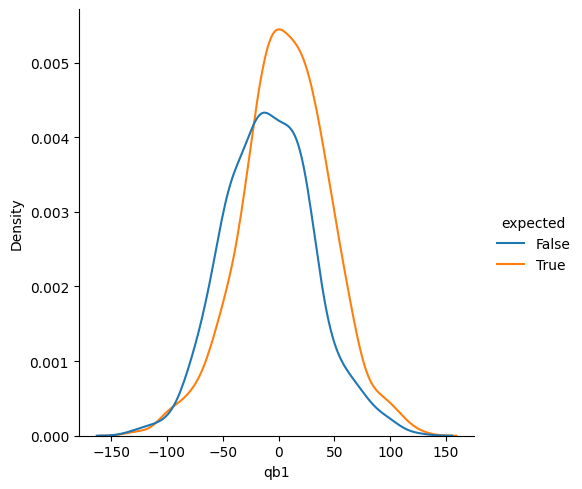

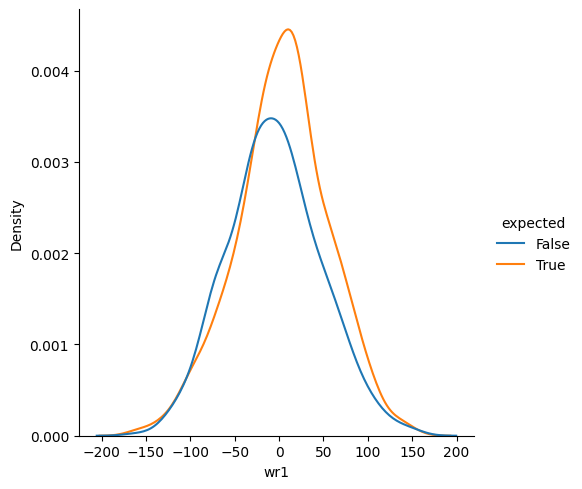

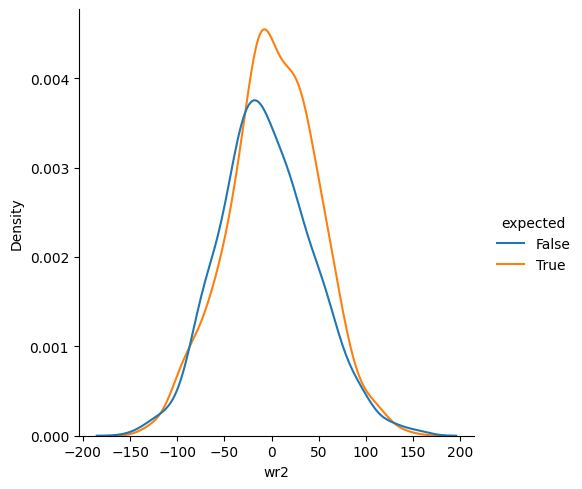

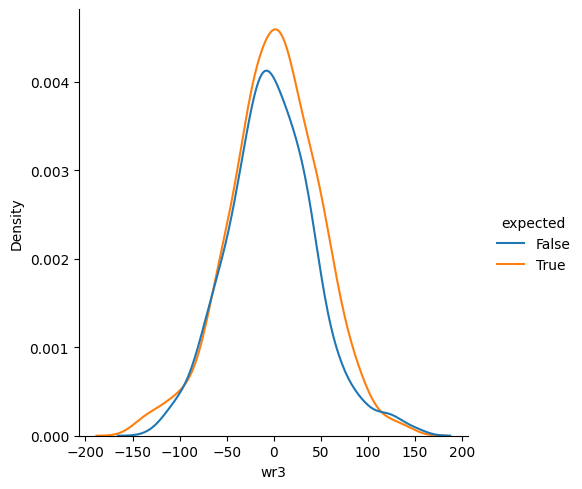

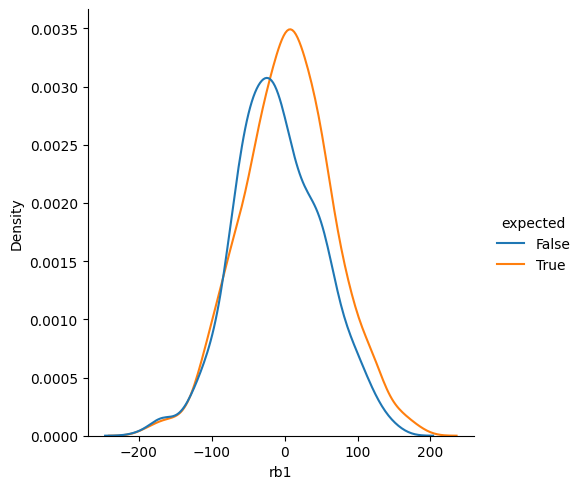

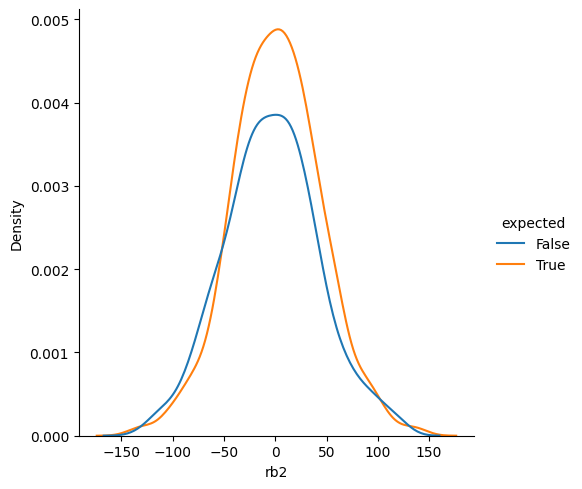

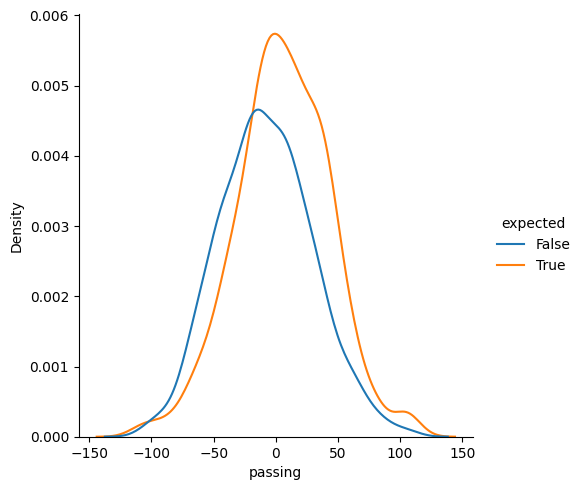

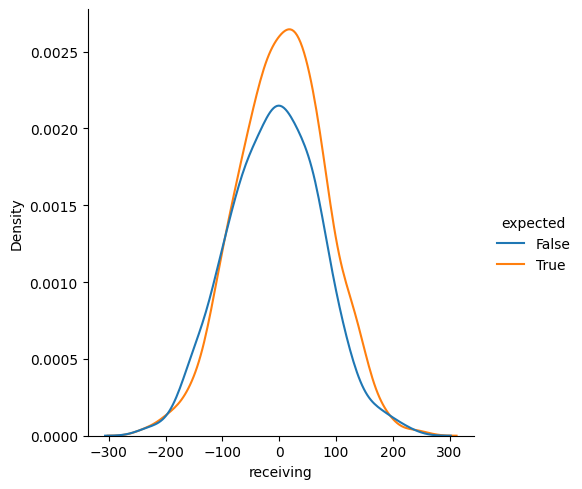

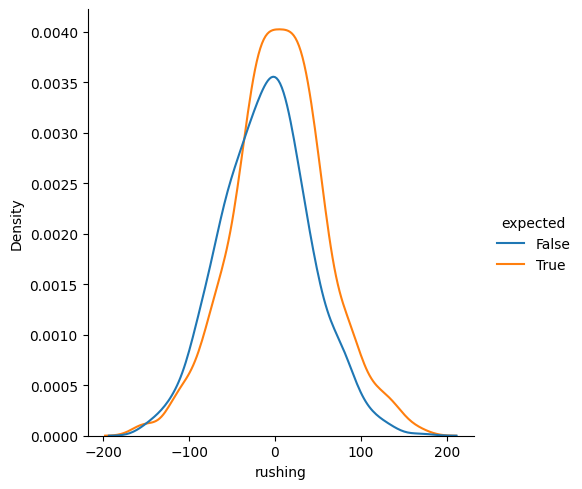

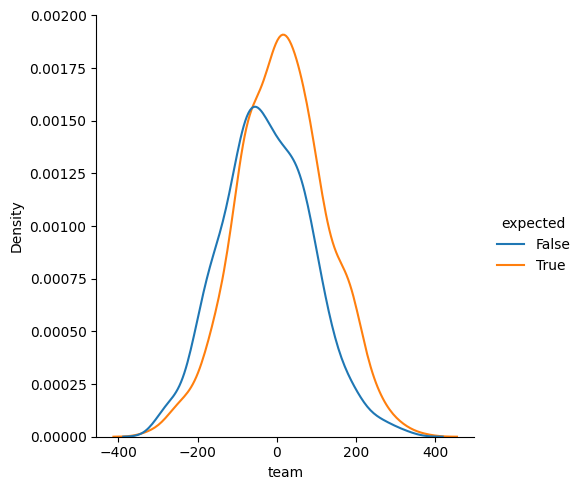

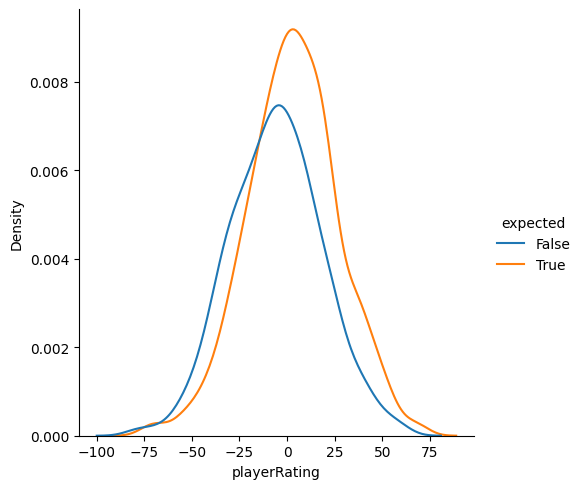

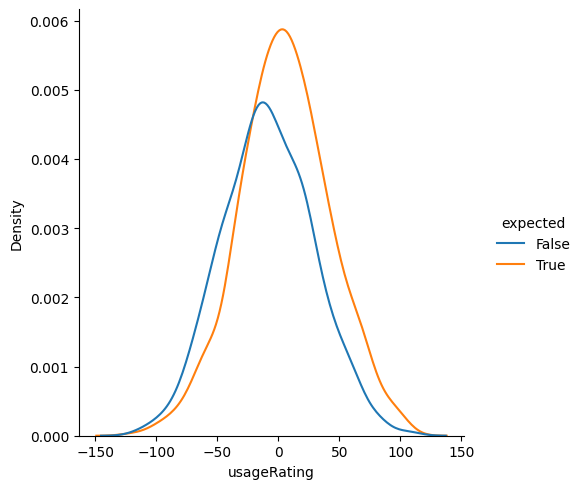

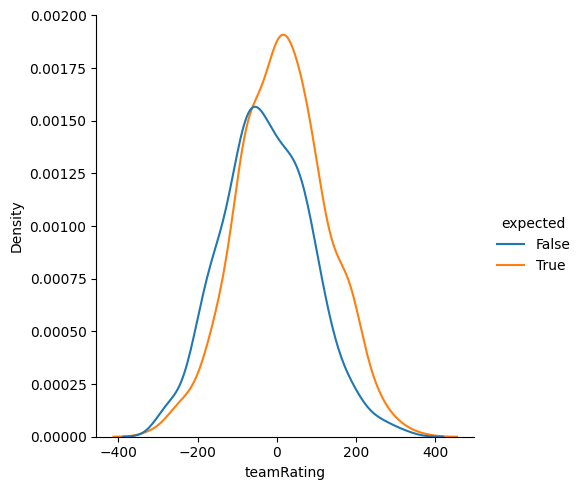

In [4]:
for compare in comparisons:
    sbn.displot(data=reduced, x=compare, hue='expected', kind="kde")

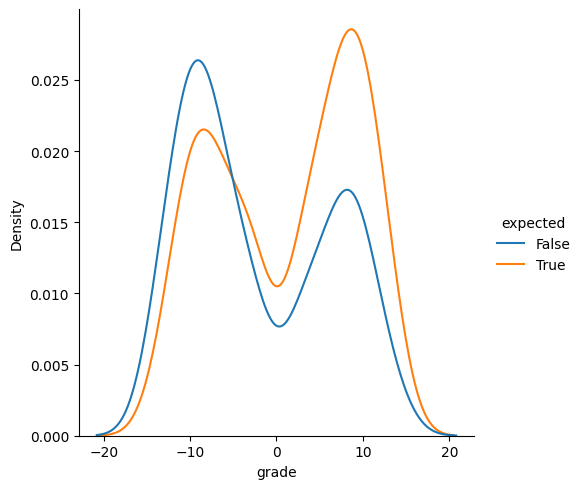

In [5]:
sbn.displot(data=reduced, x="grade", hue='expected', kind="kde")

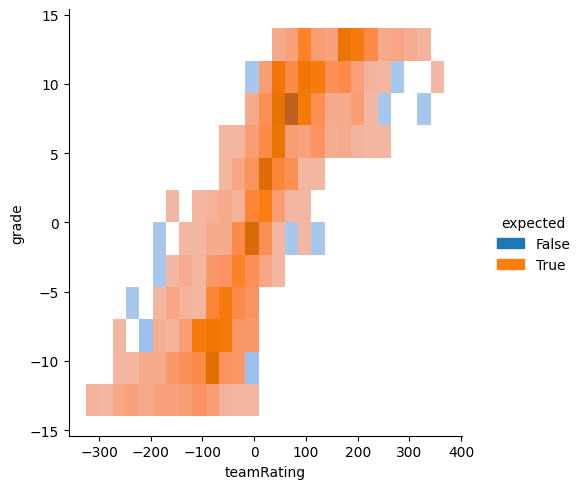

In [6]:
sbn.displot(data=reduced, x="teamRating", y="grade", hue='expected')

In [7]:
from scipy.stats import pearsonr, spearmanr

# Calculate Pearson correlation 
def show_correlation(column: str, compare: str):
    print(f"Show correlation of: {column} vs {compare}")

    pearson_corr, _ = pearsonr(reduced[column], reduced[compare])
    print(f"Pearson correlation: {pearson_corr}")

    # Calculate Spearman correlation 
    spearman_corr, _ = spearmanr(reduced[column], reduced[compare])
    print(f"Spearman correlation: {spearman_corr}")

for compare in comparisons + ['grade']:
    show_correlation(compare, 'expected')

Show correlation of: qb1 vs expected
Pearson correlation: 0.1831915425823643
Spearman correlation: 0.19307042347688075
Show correlation of: wr1 vs expected
Pearson correlation: 0.08898827830044773
Spearman correlation: 0.10138220374408081
Show correlation of: wr2 vs expected
Pearson correlation: 0.0764234867900506
Spearman correlation: 0.09043159217578203
Show correlation of: wr3 vs expected
Pearson correlation: 0.034624436343417206
Spearman correlation: 0.050632687212360444
Show correlation of: rb1 vs expected
Pearson correlation: 0.10905696220068706
Spearman correlation: 0.11377181058742276
Show correlation of: rb2 vs expected
Pearson correlation: 0.05848463972355294
Spearman correlation: 0.06018704593952824
Show correlation of: passing vs expected
Pearson correlation: 0.1799902321012168
Spearman correlation: 0.18863660833239126
Show correlation of: receiving vs expected
Pearson correlation: 0.07734970534255482
Spearman correlation: 0.07772569132149
Show correlation of: rushing vs ex

In [8]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.metrics import roc_curve, auc

def find_threshold(field, target=0.6):
    new_field = f"prob_{field}"
    reduced[new_field] = (reduced[field] - reduced[field].min()) / (
        reduced[field].max() - reduced[field].min()
    )

    fpr, tpr, thresholds = roc_curve(reduced['expected'], reduced[new_field])
    roc_auc = auc(fpr, tpr)
    print(f"Area under the ROC curve for {field}: {roc_auc}")

    ####################################
    # The optimal cut off would be where tpr is high and fpr is low
    # tpr - (1-fpr) is zero or near to zero is the optimal cut off point
    ####################################
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({
        'fpr' : pd.Series(fpr, index=i),
        'tpr' : pd.Series(tpr, index = i), 
        '1-fpr' : pd.Series(1-fpr, index = i), 
        'tf' : pd.Series(tpr - (1-fpr), index = i),
        'diff' : pd.Series((1-fpr) - tpr, index = i),
        'thresholds' : pd.Series(thresholds, index = i)
    })
    
    # This gives where the two values are .7 apart
    pos = (np.abs(roc['diff'] - target)).idxmin()

    # This gives you where the lines cross
    # pos = (roc.tf-0).abs().argsort()[:1]
    ideal = {str(key): float(value) for key, value in roc.iloc[pos].items()}
    print(ideal)
    target = ideal['thresholds'] * (reduced[field].max() - reduced[field].min()) + reduced[field].min()
    print('threshold value =>', target, '\n')

    # Plot tpr vs 1-fpr
    """
    fig, ax = pl.subplots()
    pl.plot(roc['tpr'])
    pl.plot(roc['1-fpr'], color = 'red')
    pl.xlabel('1-False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(field)
    ax.set_xticklabels([])
    """
    return int(target)

targets = {
    comparison: find_threshold(comparison)
    for comparison in comparisons+['grade']
}

print(targets)

Area under the ROC curve for qb1: 0.6118573107756515
{'fpr': 0.1424581005586592, 'tpr': 0.2576832151300236, '1-fpr': 0.8575418994413408, 'tf': -0.5998586843113172, 'diff': 0.5998586843113172, 'thresholds': 0.6241263803469512}
threshold value => 30.768331865427285 

Area under the ROC curve for wr1: 0.5587368094351335
{'fpr': 0.1787709497206704, 'tpr': 0.2198581560283688, '1-fpr': 0.8212290502793296, 'tf': -0.6013708942509608, 'diff': 0.6013708942509608, 'thresholds': 0.6457188733653378}
threshold value => 43.79883859585678 

Area under the ROC curve for wr2: 0.5523924614023271
{'fpr': 0.18435754189944134, 'tpr': 0.21513002364066194, '1-fpr': 0.8156424581005587, 'tf': -0.6005124344598968, 'diff': 0.6005124344598968, 'thresholds': 0.6130247393770842}
threshold value => 39.28000140867053 

Area under the ROC curve for wr3: 0.5293345615911883
{'fpr': 0.17737430167597765, 'tpr': 0.2198581560283688, '1-fpr': 0.8226256983240223, 'tf': -0.6027675422956535, 'diff': 0.6027675422956535, 'threshol

In [ ]:
def analyze(targets):
    filter = (True == True)
    for comparison in comparisons:
        value = targets[comparison]
        filter = filter & (run_results[comparison].abs() >= value)
        
    chosen = run_results[filter].reset_index(drop=True)

    positive = (chosen["expected"] == True)
    negative = (chosen["expected"] == False)

    for comparison in comparisons:
        value = targets[comparison]
        positive = positive & (chosen[comparison] >= value)
        negative = negative & (chosen[comparison] <= -value)
        # chosen[comparison] = chosen[comparison].astype(int)


    sub = (positive) | (negative)

    correct = chosen[sub]
    chosen['correct'] = False
    chosen.loc[sub, 'correct'] = True

    print("chosen", len(chosen.index), len(chosen.index) / total)
    print("correct", len(correct.index), len(correct.index) / len(chosen.index))

    print(correct)
    chosen[[
        'season', 
        'week', 
        'expected',
        'correct',
        'diff',
    ]+comparisons].to_parquet(
        os.path.abspath(
            os.path.join(notebook_dir, f"../../cache/parquet/chosen.parquet")
        )
    )



# analyze(154, 178, 308) => 0.65 0.22
analyze(targets)


chosen 4 0.0024154589371980675
correct 2 0.5
          qb1        wr1         wr2        wr3         rb1        rb2  \
1  -71.226669 -75.430308  -83.084866 -37.421945  -65.237620 -53.513158   
2  203.763837  55.513647  251.923723  46.064804  125.107954  36.593354   

      passing   receiving     rushing        team  playerRating  usageRating  \
1  -50.967308 -126.771890 -114.321137 -249.117901    -64.319094   -97.353445   
2  193.304064  347.977518  168.308657  599.353437    119.827886   236.530080   

   teamRating  grade                            results  expected  diff  
1 -249.117901    -14  {'loser': 'PHI', 'winner': 'HOU'}     False   -12  
2  599.353437     14  {'loser': 'MIA', 'winner': 'DAL'}      True    25  


KeyError: "['season', 'week'] not in index"